### Licensing terms 

Copyright SKA Observatory 2024. All rights reserved. 


# SKAO data processing example problem

This is a simple toy problem meant to allow data processing software engineer candidates to showcase their expertise. It implements a very naive gridding algorithm that could be used to make images from visibilities (correlated antenna voltages), a key operation of the science data processor sub-system at radio observatories.

The SKAO will have to deal with visibility data in ever-greater volumes - potentially petabytes worth for every hour of observation, which means that repeated gridding might eventually become a bottleneck. As we will not be able to store data for months at a time, making observatory operations manageable will require effectively distributing processing across hundreds of nodes.

## The problem

Take a look at the code below. Can you come up with a version that distributes the work, but still arrives at the same result?

* You can use whatever technology you want, including not using Python or converting the dataset into a different format
* To show-case distribution, you are allowed to just "distribute" to different processes within a node
* Documentation of the scalability behaviour of your code (and any bottlenecks identified) would be great

Have fun! Thanks for applying to the SKAO!

## Reference implementation

In [7]:
import numpy
import xarray
import zarr
from matplotlib import pyplot

Download the dataset from https://drive.google.com/file/d/1UIDwiYaFedc0GsQJYUYd34ASpos_842H and un-zip into same directory as the notebook:

In [8]:
dataset = xarray.open_zarr('example_simulation.zarr')
dataset

<xarray.Dataset> Size: 740MB
Dimensions:               (time: 512, baseline_id: 351, uvw_label: 3,
                           frequency: 256, baseline_antenna1_id: 351,
                           baseline_antenna2_id: 351, polarization: 1)
Coordinates:
  * baseline_antenna1_id  (baseline_antenna1_id) int32 1kB 0 0 0 0 ... 24 24 25
  * baseline_antenna2_id  (baseline_antenna2_id) int32 1kB 1 2 3 4 ... 25 26 26
  * baseline_id           (baseline_id) int32 1kB 0 1 2 3 4 ... 347 348 349 350
  * frequency             (frequency) float64 2kB 2.998e+08 ... 3.091e+08
  * polarization          (polarization) <U1 4B 'I'
  * time                  (time) float64 4kB 1.715e+09 1.715e+09 ... 1.715e+09
  * uvw_label             (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    UVW                   (time, baseline_id, uvw_label) float64 4MB ...
    VISIBILITY            (time, baseline_id, frequency) complex128 736MB ...
Attributes:
    creation_date:  2024-05-09T07:00:00+00:00.000
    intent:         Example Simulation
    version:        0.0.1

The visibilities (VISIBILITY data variable) are samples of spatial-frequency space - so its Fourier transformation is an image. For speed we want to use Fast Fourier Transformation (FFT) algorithms, which means that we first need to "grid" these visibilities to a regular grid:

In [9]:
image_size = 2048 # Size of image in pixels
c = 299792458 # Speed of light
theta = 0.0125 # Size of image on sky, directional cosines
# Allocate array for gridded visibilities
gridded = numpy.zeros((image_size, image_size), dtype=complex)
# Iterate over time (baseline UVW coordinates rotate with the earth)
for (uvws, visss) in zip(dataset.UVW, dataset.VISIBILITY):
    # Iterate over individual baselines (i.e. pairs of antennas)
    for (uvw, viss) in zip(uvws.compute().data, visss.compute().data):
        # Iterate over frequencies
        for (freq, vis) in zip(dataset.frequency.data, viss):
            # Calculate position in wavelenghts
            iu = round(theta * uvw[0] * freq / c)
            iv = round(theta * uvw[1] * freq / c)
            # Accumulate visibility at approximate location in the grid
            gridded[iu + image_size//2, iv + image_size//2] += vis

Which then allows us to use standard 2D Fourier transformation to obtain the image:

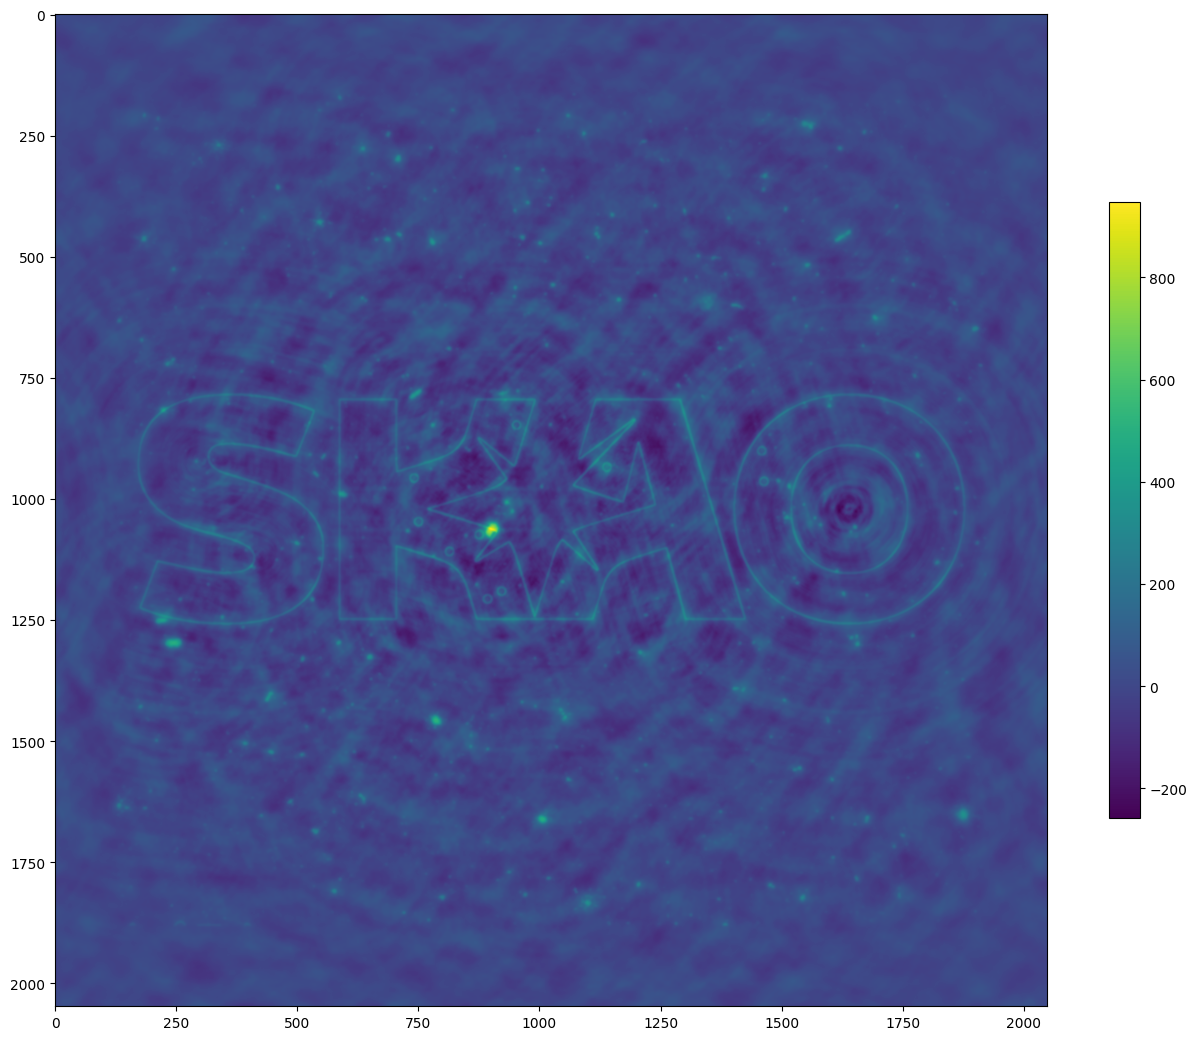

In [10]:
image = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.ifftshift(gridded))).real
pyplot.figure(figsize=(16,16)); pyplot.imshow(image); pyplot.colorbar(shrink=0.5);